In [121]:
# Import
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
import en_core_web_sm
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction import text 

In [193]:
df = pd.read_csv('/Users/antoinebertin/Downloads/wine_merge.csv')
df.head()

,description,points,price,province,variety,sweet,acidity,body,tannin,abv
0,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Pinot Gris,1.56,3.5,2.96,1.0,13.02
1,This has great depth of flavor with its fresh ...,87,27.0,Alsace,Pinot Gris,1.56,3.5,2.96,1.0,13.02
2,This wine has a touch of perceptible sweetness...,88,18.0,California,Pinot Gris,1.56,3.5,2.96,1.0,13.02
3,"Fresh apple, lemon and pear flavors are accent...",88,18.0,New York,Pinot Gris,1.56,3.5,2.96,1.0,13.02
4,"Beautiful deep gold color. Intense, concentrat...",90,112.0,Alsace,Pinot Gris,1.56,3.5,2.96,1.0,13.02


In [194]:
df[['points', 'price']].corr()

,points,price
points,1.000000,0.450188
price,0.450188,1.000000


# Lemmatization First

- Why: Lemmatization standardizes the text by converting words to their base form. This process is beneficial before applying TF-IDF as it helps in reducing the feature space (the number of unique words).
- Result: You'll have a more meaningful representation of your text data, as similar words (e.g., "running" and "ran") will be treated as the same.

In [195]:
# Loading SpaCy model for lemmatization
nlp = spacy.load('en_core_web_sm')

# Function for lemmatizing text
def lemmatize_text(text):
    return ' '.join([token.lemma_ for token in nlp(text) if not token.is_stop])

In [196]:
# Lemmatizing the 'description' column
df['lemmatized_description'] = df['description'].apply(lemmatize_text)

In [197]:
df.head()

,description,points,price,province,variety,sweet,acidity,body,tannin,abv,lemmatized_description
0,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Pinot Gris,1.56,3.5,2.96,1.0,13.02,"tart snappy , flavor lime flesh rind dominate ..."
1,This has great depth of flavor with its fresh ...,87,27.0,Alsace,Pinot Gris,1.56,3.5,2.96,1.0,13.02,great depth flavor fresh apple pear fruit touc...
2,This wine has a touch of perceptible sweetness...,88,18.0,California,Pinot Gris,1.56,3.5,2.96,1.0,13.02,wine touch perceptible sweetness tropical nose...
3,"Fresh apple, lemon and pear flavors are accent...",88,18.0,New York,Pinot Gris,1.56,3.5,2.96,1.0,13.02,"fresh apple , lemon pear flavor accent hint sm..."
4,"Beautiful deep gold color. Intense, concentrat...",90,112.0,Alsace,Pinot Gris,1.56,3.5,2.96,1.0,13.02,"beautiful deep gold color . intense , concentr..."


# Apply TF-IDF

In [198]:
# Initializing the TF-IDF Vectorizer
# max_df=100 words that appear more than 100 documents are removed
# min_df=5 means a word must appear in at least 5 documents to be considered.

custom_stop_words = ['10', '100', '12', '14', '15', '20', '2009', '2010', '2011',
       '2012', '2014', '2015', '2016', '2017', '2018', '2019', '2020',
       '2021', '2022', '2023', '2024', '2025', '2030', '25', '30', '40',
       '50', '60', '70', '80', 'flavor', 'wine']
# Combine custom stop words with the default English stop words
default_stop_words = list(text.ENGLISH_STOP_WORDS)
combined_stop_words = default_stop_words + custom_stop_words

vectorizer = TfidfVectorizer(stop_words=combined_stop_words, min_df=400)#max_df=100)

# Fitting and transforming the lemmatized descriptions
tfidf_results = vectorizer.fit_transform(df['lemmatized_description'])

In [199]:
tfidf_results.shape

(64010, 578)

In [200]:
feature_names = vectorizer.get_feature_names_out()
feature_names

array(['accent', 'accessible', 'acid', 'acidic', 'acidity', 'add',
       'aftertaste', 'age', 'aged', 'aging', 'alcohol', 'allow', 'almond',
       'alongside', 'ample', 'anise', 'appeal', 'appellation', 'apple',
       'approachable', 'apricot', 'aroma', 'aromas', 'aromatic', 'asian',
       'assertive', 'astringent', 'attractive', 'austere', 'backbone',
       'background', 'bacon', 'bake', 'baked', 'balance', 'balanced',
       'balsamic', 'banana', 'barrel', 'base', 'basic', 'bean',
       'beautiful', 'beautifully', 'beef', 'begin', 'berry', 'big', 'bit',
       'bite', 'bitter', 'black', 'blackberry', 'blend', 'blossom',
       'blue', 'blueberry', 'boast', 'bodied', 'body', 'bold', 'bone',
       'bottle', 'bottling', 'bouquet', 'boysenberry', 'brace', 'brambly',
       'bright', 'brighten', 'bring', 'brisk', 'broad', 'brown', 'build',
       'burn', 'burst', 'butter', 'butterscotch', 'buttery', 'cab',
       'cabernet', 'cake', 'california', 'candy', 'caramel', 'carry',
      

In [201]:
def get_top_words_per_row(tfidf_results, feature_name_vectoriser, n=5):
    top_words = []

    # Loop through each row in the TF-IDF matrix
    for row_index in range(tfidf_results.shape[0]):
        row = tfidf_results[row_index]
        top_n_indices = row.toarray()[0].argsort()[-n:][::-1]        
        top_n_words = [feature_name_vectoriser[i] for i in top_n_indices]
        top_words.append(top_n_words)
    return top_words

top_words_tuples = get_top_words_per_row(tfidf_results, feature_names, n=5)

In [202]:
# Add the new column to your DataFrame
df['relevant_words'] = top_words_tuples

In [203]:
df.iloc[56]['lemmatized_description']

'dramatic increase production wine . Gassy thin , show veneer slightly sweet apple finish dusting powdered sugar .'

In [204]:
df.iloc[56]['relevant_words']

['production', 'sugar', 'slightly', 'sweet', 'apple']

In [208]:
df.head()

,description,points,price,province,variety,sweet,acidity,body,tannin,abv,lemmatized_description,relevant_words
0,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Pinot Gris,1.56,3.5,2.96,1.0,13.02,"tart snappy , flavor lime flesh rind dominate ...","[steel, rind, ferment, dominate, pineapple]"
1,This has great depth of flavor with its fresh ...,87,27.0,Alsace,Pinot Gris,1.56,3.5,2.96,1.0,13.02,great depth flavor fresh apple pear fruit touc...,"[depth, great, balanced, pear, touch]"
2,This wine has a touch of perceptible sweetness...,88,18.0,California,Pinot Gris,1.56,3.5,2.96,1.0,13.02,wine touch perceptible sweetness tropical nose...,"[straightforward, wrap, grow, variety, sweetness]"
3,"Fresh apple, lemon and pear flavors are accent...",88,18.0,New York,Pinot Gris,1.56,3.5,2.96,1.0,13.02,"fresh apple , lemon pear flavor accent hint sm...","[nut, appeal, pair, bold, smoke]"
4,"Beautiful deep gold color. Intense, concentrat...",90,112.0,Alsace,Pinot Gris,1.56,3.5,2.96,1.0,13.02,"beautiful deep gold color . intense , concentr...","[honey, sweet, succulent, note, beautiful]"


## word cloud

In [206]:
# Convert the sparse matrix to a dense matrix
dense_tfidf_matrix = tfidf_results.todense()

# Calculate the average TF-IDF score for each term
avg_tfidf_scores = np.mean(dense_tfidf_matrix, axis=0)

# Create a dictionary of words and their average TF-IDF scores
word_scores = {feature_names[i]: avg_tfidf_scores[0,i] for i in range(len(feature_names))}

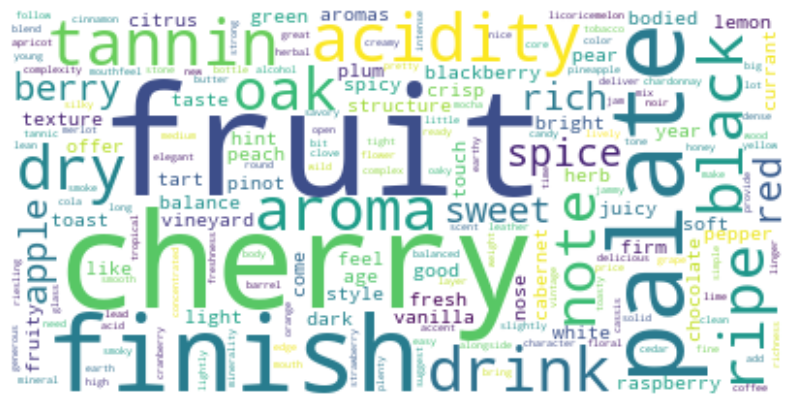

In [207]:
# Create a WordCloud object
wordcloud = WordCloud(background_color='white')

# Generate the word cloud using the aggregated TF-IDF scores
wordcloud.generate_from_frequencies(word_scores)

# Plotting the word cloud
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# new DB

In [213]:
db_tfidf = pd.DataFrame(tfidf_results.toarray(), columns=feature_names)

In [217]:
df.drop(columns={'lemmatized_description', 'description'}, inplace=True)

In [218]:
df

,points,price,province,variety,sweet,acidity,body,tannin,abv,relevant_words
0,87,14.0,Oregon,Pinot Gris,1.56,3.5,2.96,1.00,13.02,"[steel, rind, ferment, dominate, pineapple]"
1,87,27.0,Alsace,Pinot Gris,1.56,3.5,2.96,1.00,13.02,"[depth, great, balanced, pear, touch]"
2,88,18.0,California,Pinot Gris,1.56,3.5,2.96,1.00,13.02,"[straightforward, wrap, grow, variety, sweetness]"
3,88,18.0,New York,Pinot Gris,1.56,3.5,2.96,1.00,13.02,"[nut, appeal, pair, bold, smoke]"
4,90,112.0,Alsace,Pinot Gris,1.56,3.5,2.96,1.00,13.02,"[honey, sweet, succulent, note, beautiful]"
...,...,...,...,...,...,...,...,...,...,...
64005,85,90.0,Northern Spain,Garnacha,1.17,3.0,3.29,2.83,13.46,"[tannic, chocolaty, extract, hot, lack]"
64006,85,18.0,Northern Spain,Garnacha,1.17,3.0,3.29,2.83,13.46,"[chunky, low, raisin, prune, nuance]"
64007,91,20.0,Washington,Garnacha,1.17,3.0,3.29,2.83,13.46,"[pleasing, succulent, sense, elegance, jammy]"
64008,85,10.0,Northern Spain,Garnacha,1.17,3.0,3.29,2.83,13.46,"[everyday, heavy, bake, bit, feel]"


In [219]:
combined_df = pd.concat([df, db_tfidf], axis=1)

In [221]:
combined_df.head()

,points,price,province,variety,sweet,acidity,body,tannin,abv,relevant_words,...,wound,wrap,year,yellow,young,youthful,zest,zesty,zin,zinfandel
0,87,14.0,Oregon,Pinot Gris,1.56,3.5,2.96,1.0,13.02,"[steel, rind, ferment, dominate, pineapple]",...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,87,27.0,Alsace,Pinot Gris,1.56,3.5,2.96,1.0,13.02,"[depth, great, balanced, pear, touch]",...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,88,18.0,California,Pinot Gris,1.56,3.5,2.96,1.0,13.02,"[straightforward, wrap, grow, variety, sweetness]",...,0.0,0.311638,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,88,18.0,New York,Pinot Gris,1.56,3.5,2.96,1.0,13.02,"[nut, appeal, pair, bold, smoke]",...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,90,112.0,Alsace,Pinot Gris,1.56,3.5,2.96,1.0,13.02,"[honey, sweet, succulent, note, beautiful]",...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [225]:
combined_df.to_csv('/Users/antoinebertin/Documents/jedha/project/wine_final.csv')